In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils



# Colormap

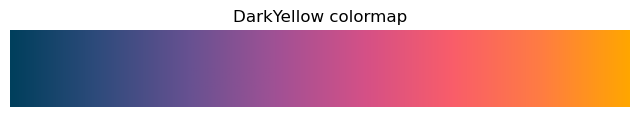

In [2]:
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

plt.figure(figsize=(8, 1))
plt.imshow(gradient, aspect="auto", cmap=custom_cmap)
plt.axis("off")
plt.title("DarkYellow colormap")
plt.show()

#with open("DarkYellow_cmap.pkl", "wb") as f:
#    pickle.dump(custom_cmap, f)


# Variabili di base per il codice

In [20]:
# File containing the images
#file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\febbraio\arcturus_633nm_10ms.ome.tif")
# Select the specific image to study
#imagenumber = 901

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=6000 #7000 #1100 #9500 #8000 #9000 #6500 #9000


# Plate scale arcseconds/pixels
#plate_scale = 0.0377 gennaio
plate_scale = 0.0109

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
#wavelength = 700e-9  
wavelength = 633e-9# Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds/plate_scale) 
# Radius use for the fit of the speckles (in pixels)
radius = check_radius*1.5 

print ("Check radius in pixels: ", check_radius)

imagenumber = 500


Diffraction limit in arcseconds and pixels:  0.17504418560439558
Check radius in pixels:  16


## Funzioni

In [7]:
from astropy.modeling import models, fitting


def fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale):
    fwhm_results = []
    centers = []
    
    for speckle in filtered_speckles:
        y_ref, x_ref = speckle  
        masked_data = data.copy() 
        y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data[masked_data < 0] = 0 
        
        ###########################################################################
        #Se attivo, fa il fit in una regione circolare
        #distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
        #circular_mask = distance <= radius
        #masked_data = np.where(circular_mask, masked_data, 0)
        ##############################################################################
        
        # Set border pixels to 0
        masked_data[0, :] = 0
        masked_data[-1, :] = 0
        masked_data[:, 0] = 0
        masked_data[:, -1] = 0

        gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
        gaussian_model.amplitude.min = speckle_threshold
        gaussian_model.amplitude.max = masked_data.max()
        gaussian_model.x_mean.min = x_ref - 1
        gaussian_model.x_mean.max = x_ref + 1
        gaussian_model.y_mean.min = y_ref - 1
        gaussian_model.y_mean.max = y_ref + 1

        fitter = fitting.LevMarLSQFitter()
        fitted_model = fitter(gaussian_model, x, y, masked_data)

        fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
        fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
        fwhm_results.append((fwhm_y, fwhm_x))
        centers.append((fitted_model.y_mean.value, fitted_model.x_mean.value))

    return np.array(fwhm_results), np.array(centers)

# Example usage:
#fwhm_results, centers = fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale)

def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y

## Apertura file .tiff

showing the image 501 of the stack


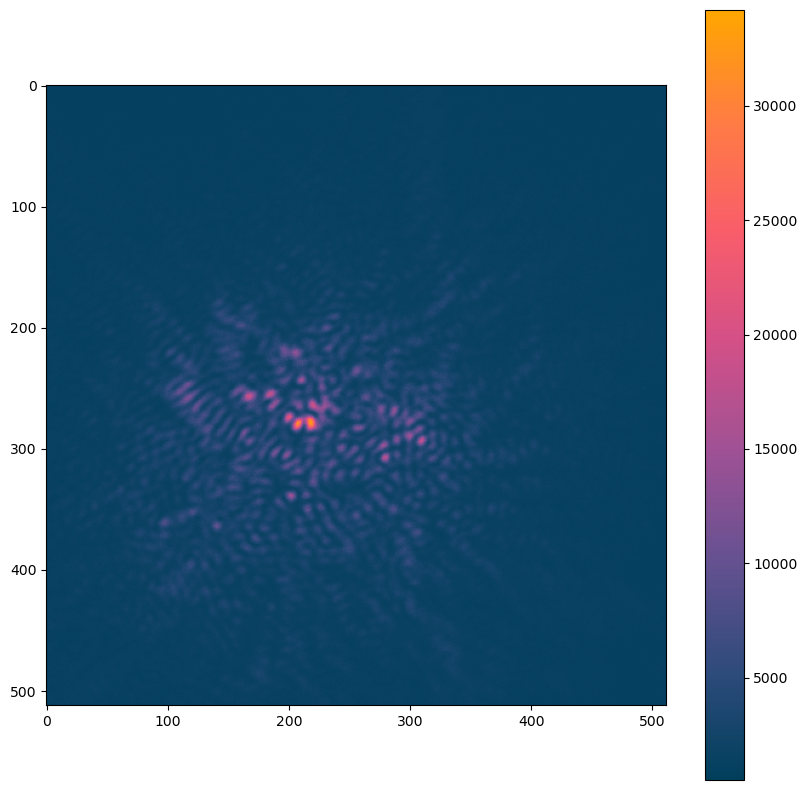

In [11]:

ome_data = tifffile.imread(file) 

print(f'showing the image {imagenumber+1} of the stack')
plt.figure(figsize=(10, 10))
plt.imshow(ome_data[imagenumber], cmap=custom_cmap)
#plt.title('Single image')
plt.colorbar()
plt.show()



## Stima del noise e pulizia dell'immagine

In [21]:
data_raw = ome_data[imagenumber]
data_clean = data_raw.copy()
poisson_error = np.sqrt(data_raw)

# Estimate the background error (assuming a constant background level)
background_level = np.median(data_raw)
background_error = np.sqrt(background_level)


noise = np.sqrt(np.mean(poisson_error**2) + background_error**2)

# Estimate the background using the total error
background_estimate = data_raw - noise
background_estimate[background_estimate < 0] = 0

print(f"Background level: {background_level}")
print(f"Background error: {background_error}")

data = data_raw - background_level
data[data < 0] = 0


Background level: 1487.0
Background error: 38.561638969317684


## Salvataggio in file fits

In [24]:
immagine = data  #sceglie l'immagine
immagine_flipped = np.flip(immagine, axis=1)

hdu = fits.PrimaryHDU(immagine_flipped)
hdu.writeto('c:/Users/buonc/Desktop/10001th_image.fits', overwrite=True)

## Ricerca delle speckle

In [22]:

speckle_coords = np.column_stack(np.where(data > speckle_threshold))
print ('Initial speckles found:', len(speckle_coords))
real_speckles = []

for coord in speckle_coords:
    y, x = coord
    max_count = data[y, x]
    speckle = coord
    
    # Check the surrounding pixels within the radius
    for dy in range(-check_radius, check_radius + 1):
        for dx in range(-check_radius, check_radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                if data[ny, nx] > max_count:
                    max_count = data[ny, nx]
                    speckle = [ny, nx]
                    
    if not any(np.array_equal(speckle, x) for x in real_speckles):
        real_speckles.append(speckle)
        
real_speckles = np.array(real_speckles)

filtered_speckles = []

for speckle in real_speckles:
    y, x = speckle
    max_count = data[y, x]
    keep_speckle = True
    
    # Check for adjacent speckles
    for dy in range(-1, 2):
        for dx in range(-1, 2):
            ny, nx = y + dy, x + dx
            if [ny, nx] in filtered_speckles:
                if data[ny, nx] > max_count:
                    keep_speckle = False
                else:
                    filtered_speckles.remove([ny, nx])
    
    if keep_speckle:
        filtered_speckles.append([y, x])

# Convert filtered speckles to numpy array
filtered_speckles = np.array(filtered_speckles)
print("Filtered speckles:", len(filtered_speckles))



Initial speckles found: 2425
Filtered speckles: 56


# Fit delle speckle di un'immagine sola

In [24]:
fwhm_results = []
fwhm_tot_single_image = []
#radius = 3
#imagenumber = 901
#speckle_threshold = 8000

data_raw = ome_data[imagenumber]
data_clean = data_raw.copy()
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0
print(f"Background level: {background_level}")

speckle_coords = np.column_stack(np.where(data > speckle_threshold))
print ('Initial speckles found:', len(speckle_coords))
real_speckles = []

for coord in speckle_coords:
    y, x = coord
    max_count = data[y, x]
    speckle = coord
    
    # Check the surrounding pixels within the radius
    for dy in range(-check_radius, check_radius + 1):
        for dx in range(-check_radius, check_radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                if data[ny, nx] > max_count:
                    max_count = data[ny, nx]
                    speckle = [ny, nx]
                    
    if not any(np.array_equal(speckle, x) for x in real_speckles):
        real_speckles.append(speckle)
        
real_speckles = np.array(real_speckles)

filtered_speckles = []

for speckle in real_speckles:
    y, x = speckle
    max_count = data[y, x]
    keep_speckle = True
    
    # Check for adjacent speckles
    for dy in range(-1, 2):
        for dx in range(-1, 2):
            ny, nx = y + dy, x + dx
            if [ny, nx] in filtered_speckles:
                if data[ny, nx] > max_count:
                    keep_speckle = False
                else:
                    filtered_speckles.remove([ny, nx])
    
    if keep_speckle:
        filtered_speckles.append([y, x])


filtered_speckles = np.array(filtered_speckles)
print("Filtered speckles:", len(filtered_speckles))
#############################################################
#############################################################


for speckle in filtered_speckles:
    
    masked_data = data.copy() 
    y_ref, x_ref = speckle  
    # y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
   
    # masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    # masked_data[masked_data < 0] = 0 
    
    y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
    circular_mask = distance <= radius
    masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    
    # se attivo fa il fit in una regione circolare
    masked_data = np.where(circular_mask, masked_data, 0) 
    
    # Set border pixels to 0
    masked_data[0, :] = 0
    masked_data[-1, :] = 0
    masked_data[:, 0] = 0
    masked_data[:, -1] = 0

    gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
    gaussian_model.amplitude.min = speckle_threshold
    gaussian_model.amplitude.max = masked_data.max()
    gaussian_model.x_mean.min = x_ref - 1
    gaussian_model.x_mean.max = x_ref + 1
    gaussian_model.y_mean.min = y_ref - 1
    gaussian_model.y_mean.max = y_ref + 1

    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gaussian_model, x, y, masked_data)

    fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
    fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
    fwhm_results.append((fwhm_y, fwhm_x))

fwhm_tot_single_image = np.array(fwhm_results)
#print (fwhm_tot_single_image)
#print (fwhm_tot_single_image[0,1])
#print(len(fwhm_tot_single_image))
#print(fwhm_tot_single_image.shape)
#print(fwhm_tot_single_image[:,1])
print(np.mean(fwhm_tot_single_image[:,1]))
print(np.mean(fwhm_tot_single_image[:,0]))
print(np.mean(fwhm_tot_single_image))

Background level: 1487.0
Initial speckles found: 2425
Filtered speckles: 56


TypeError: slice indices must be integers or None or have an __index__ method

In [77]:
fwhm_tot_single_image = []
centers = []
fwhm_tot_single_image, centers = fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale)

## Istogramma delle FWHM delle speckle

(array([ 0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10')])

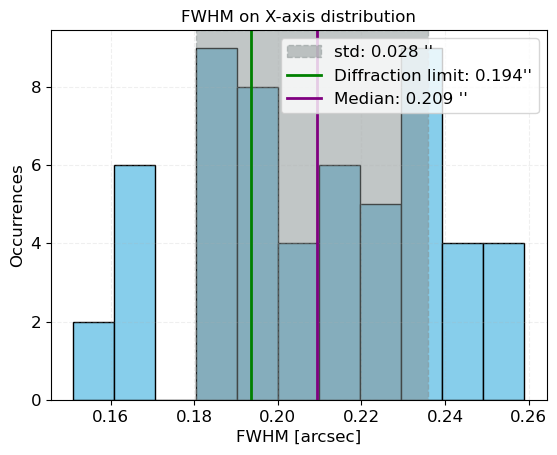

In [9]:
from astropy.stats import sigma_clip

# Per ora fa solo FWHM in X
#clipped_fwhm_x = sigma_clip(fwhm_tot_single_image[:, 1], sigma=2, maxiters=5)
#clipped_fwhm_y = sigma_clip(fwhm_tot_single_image[:, 0], sigma=2, maxiters=5)
#fwhm_tot_clean = fwhm_tot_single_image[~clipped_fwhm_x.mask]

fwhm_x_clipped = fwhm_tot_single_image.copy()
fwhm_x_clipped = sigma_clip(fwhm_tot_single_image[:, 1], sigma=3, maxiters=1)  # o 1 a 3 sigma o 3 a 3.5 sigma
fwhm_x_tot_clean = fwhm_tot_single_image[~fwhm_x_clipped.mask]


def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y

#####################################
arr = fwhm_x_tot_clean[:,1]
#####################################

extraticks=[diffraction_limit_arcseconds,np.mean(arr)]

num_bins= int(len(arr) / 5)
bin_counts, bins, _ = plt.hist(arr, bins=num_bins, histtype='bar', align='mid', color='skyblue', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('FWHM [arcsec]', fontsize='large')
plt.ylabel('Occurrences', fontsize='large')
plt.title('FWHM on X-axis distribution', fontsize='large')

#plt.axvline(np.mean(arr), ls='-', color='#e52704', label=f"mean value: {np.mean(arr):.3f} '' ", linewidth=0.5)
plt.axvspan(xmin=np.mean(arr)-np.std(arr), xmax=np.mean(arr)+np.std(arr), alpha=0.5, color='#858e8e', label=f"std: {np.std(arr):.3f} ''", ls='--')
plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=2, label=f"Diffraction limit: {diffraction_limit_arcseconds:.3f}''")
plt.axvline(np.median(arr), color='purple', linestyle='-', linewidth=2, label=f"Median: {np.median(arr):.3f} ''")
#plt.text(np.mean(arr), max(bin_counts) * 0.9, f"{np.mean(arr):.2f}", color='#e52704', ha='center')
#plt.text(diffraction_limit_arcseconds, max(bin_counts) * 0.8, f"{diffraction_limit_arcseconds:.2f}", color='green', ha='center')
x, y = gaussiana(bins, np.mean(arr), np.std(arr))
#plt.xticks(list(plt.xticks()[0]) + [round(tick, 3) for tick in extraticks])
#plt.xlim(0.17, 0.25)
#plt.plot(x, y * len(arr) * (bins[1] - bins[0]), color='red', linestyle='-') 
#plt.legend(loc='upper left', fontsize='small')
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')



In [ ]:
single_image[:, 1], sigma=3, maxiters=1)  # o 1 a 3 sigma o 3 a 3.5 sigma
fwhm_x_tot_clean = fwhm_single_image[~fwhm_x_clipped.mask]


def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y

#####################################
arr = fwhm_tot_clean[:,1]
#####################################

num_bins= int(len(arr) / 5)
bin_counts, bins, _ = plt.hist(arr, bins=num_bins, histtype='bar', align='mid', color=['skyblue'], edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('FWHM [arcsec]', fontsize='small')
plt.ylabel('Number of Elements', fontsize='small')
plt.title('Median FWHM distribution', fontsize='medium')
#plt.xlim(0.15, 0.25)
plt.axvline(np.mean(arr), ls='-', color='#e52704', label=f'mean value ({np.mean(arr):.3f})', linewidth=0.5)
plt.axvspan(xmin=np.mean(arr)-np.std(arr), xmax=np.mean(arr)+np.std(arr), alpha=0.3, color='#858e8e', label='std', ls='--')
plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=1.2, label='Diffraction limit')
plt.axvline(np.median(arr), color='black', linestyle='-', linewidth=1.2, label='Median')
plt.text(np.mean(arr), max(bin_counts) * 0.9, f"{np.mean(arr):.2f}", color='#e52704', ha='center')
plt.text(diffraction_limit_arcseconds, max(bin_counts) * 0.8, f"{diffraction_limit_arcseconds:.2f}", color='green', ha='center')
x, y = gaussiana(bins, np.mean(arr), np.std(arr))
plt.plot(x, y * len(arr) * (bins[1] - bins[0]), color='red', linestyle='-') 
plt.legend(loc='best', fontsize='small')



In [56]:
print(len(fwhm_tot_clean))
print(len(fwhm_tot_single_image))
print(np.min(fwhm_tot_clean))
print(np.min(fwhm_tot_single_image))
print(np.max(fwhm_tot_clean))
print(np.max(fwhm_tot_single_image))

80
84
0.14230991507608481
0.13076383537318487
0.2986801267757696
0.30065773136476037


### Controllo visivo delle fwhm più grandi

Indices of FWHM in the last 2 bins: [ 1  7 16 39 42 48 55 63 69 78]
Corresponding speckles: [[166 248]
 [175 262]
 [184 263]
 [205 255]
 [206 270]
 [211 287]
 [209 268]
 [226 232]
 [225 265]
 [228 242]]
Correspondent FWHM (in x): [7.48830104 6.84698458 7.29153422 6.90355315 6.85645466 6.83116545
 7.01368432 6.90468554 7.10199428 7.37421133]
Correspondent FWHM (in y): [5.02179352 5.38873316 4.88201886 5.15307735 4.53308863 4.47606225
 3.93698878 4.76315031 4.30218054 4.07075095]
Counts at speckle positions: [ 7811. 10024. 17200. 15920. 25802. 15022. 17776.  6964.  7078.  7338.]


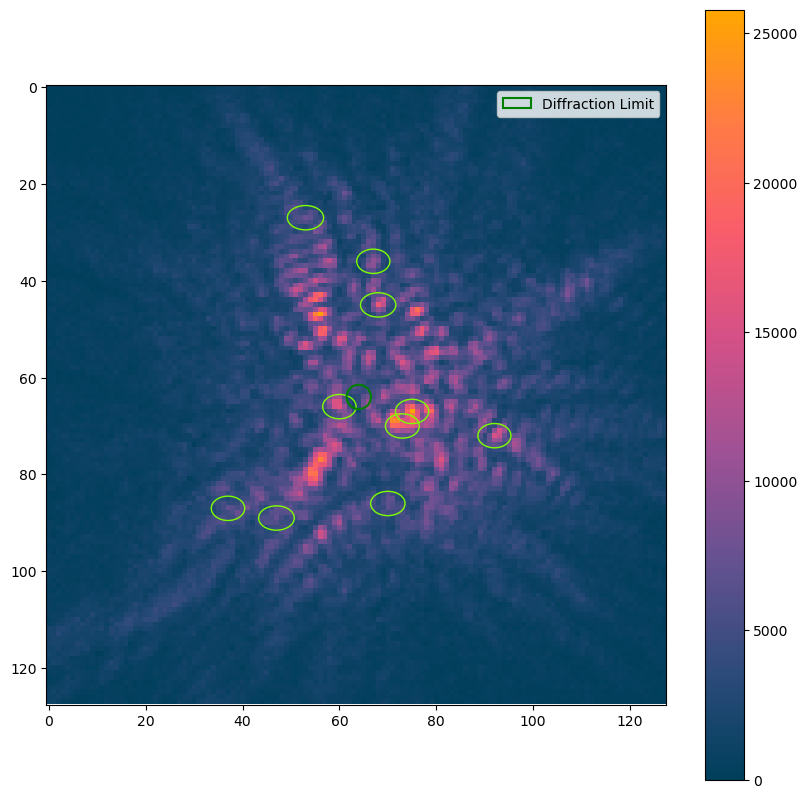

In [57]:
from matplotlib import patches

# selezione ultimi bin
bins_indices = np.where((fwhm_tot_clean[:, 1] >= bins[-4]) & (fwhm_tot_clean[:, 1] <= bins[-1]))[0]

#seleziona primim bin
#bins_indices = np.where((fwhm_tot_clean[:, 1] >= bins[0]) & (fwhm_tot_clean[:, 1] <= bins[3]))[0]

corresponding_fwhms = fwhm_tot_clean[bins_indices, 1]
largest_speckles = filtered_speckles[bins_indices]
speckle_counts = data[largest_speckles[:, 0], largest_speckles[:, 1]]

print("Indices of FWHM in the last 2 bins:", bins_indices)
print("Corresponding speckles:", largest_speckles)
print("Correspondent FWHM (in x):", corresponding_fwhms/plate_scale)
print("Correspondent FWHM (in y):", fwhm_tot_clean[bins_indices,0]/plate_scale)
print("Counts at speckle positions:", speckle_counts)

center_x = int(largest_speckles[:, 1].mean())
center_y = int(largest_speckles[:, 0].mean())

zoom_factor = 4   
####################### ridefinendo le x1, x2, y1,y2 si inverte l'immagine se serve  ##############################
x1 = max(center_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(center_x + data.shape[1] // (2 * zoom_factor), data.shape[1]) 
y1 = max(center_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(center_y + data.shape[0] // (2 * zoom_factor), data.shape[0])
zoomed_image = data[y1:y2, x1:x2]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(zoomed_image, cmap=custom_cmap, origin='upper')
for speckle, fwhm in zip(largest_speckles, corresponding_fwhms):
    y, x = speckle
    ellipse = patches.Ellipse((x - x1, y - y1), fwhm/plate_scale, fwhm_tot_clean[bins_indices, 0][0]/plate_scale, edgecolor='chartreuse', facecolor='none')
    ax.add_patch(ellipse)
    #ax.plot(x - x1, y - y1, 'bo', markersize=3, color='chartreuse')
diffraction_circle = patches.Circle((center_x - x1, center_y - y1), diffraction_limit_arcseconds / plate_scale / 2, edgecolor='green', facecolor='none', linestyle='-', linewidth=1.5, label='Diffraction Limit')
ax.add_patch(diffraction_circle)
ax.legend()
plt.colorbar(ax.imshow(zoomed_image, cmap=custom_cmap, origin='upper'))
#plt.title("Zoomed Image with Largest Speckles and FWHM Circles")
plt.show()


# diffr limit sopra le speckle

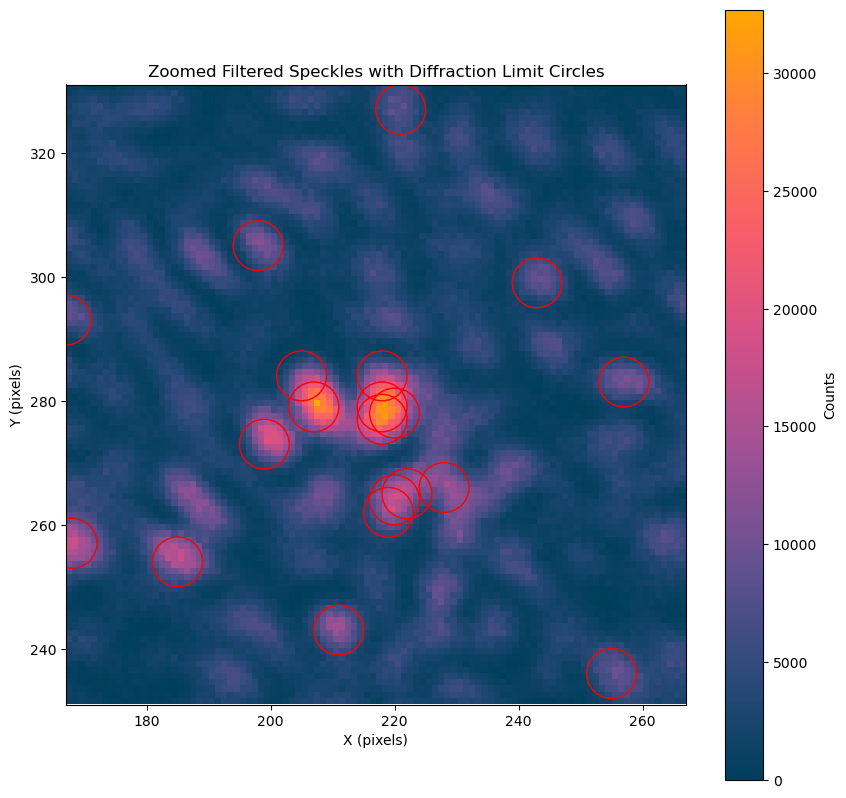

In [ ]:
from matplotlib.patches import Circle

# Calculate the centroid of the speckles
centroid_y, centroid_x = filtered_speckles.mean(axis=0).astype(int)

# Define the zoom region centered on the centroid
zoom_size = 50
x_min = max(centroid_x - zoom_size, 0)
x_max = min(centroid_x + zoom_size, data.shape[1])
y_min = max(centroid_y - zoom_size, 0)
y_max = min(centroid_y + zoom_size, data.shape[0])

# Extract the zoomed region
zoomed_data = data[y_min:y_max, x_min:x_max]

plt.figure(figsize=(10, 10))
plt.imshow(zoomed_data, cmap=custom_cmap, origin='lower', extent=(x_min, x_max, y_min, y_max))
plt.colorbar(label='Counts')
plt.title('Zoomed Filtered Speckles with Diffraction Limit Circles')

# Add circles for each filtered speckle within the zoomed region
for speckle in filtered_speckles:
    y, x = speckle
    if x_min <= x < x_max and y_min <= y < y_max:
        circle = Circle((x, y), radius=diffraction_limit_arcseconds*0.5 / ( plate_scale), 
                        edgecolor='red', facecolor='none', linestyle='-', linewidth=1)
        plt.gca().add_patch(circle)

plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()


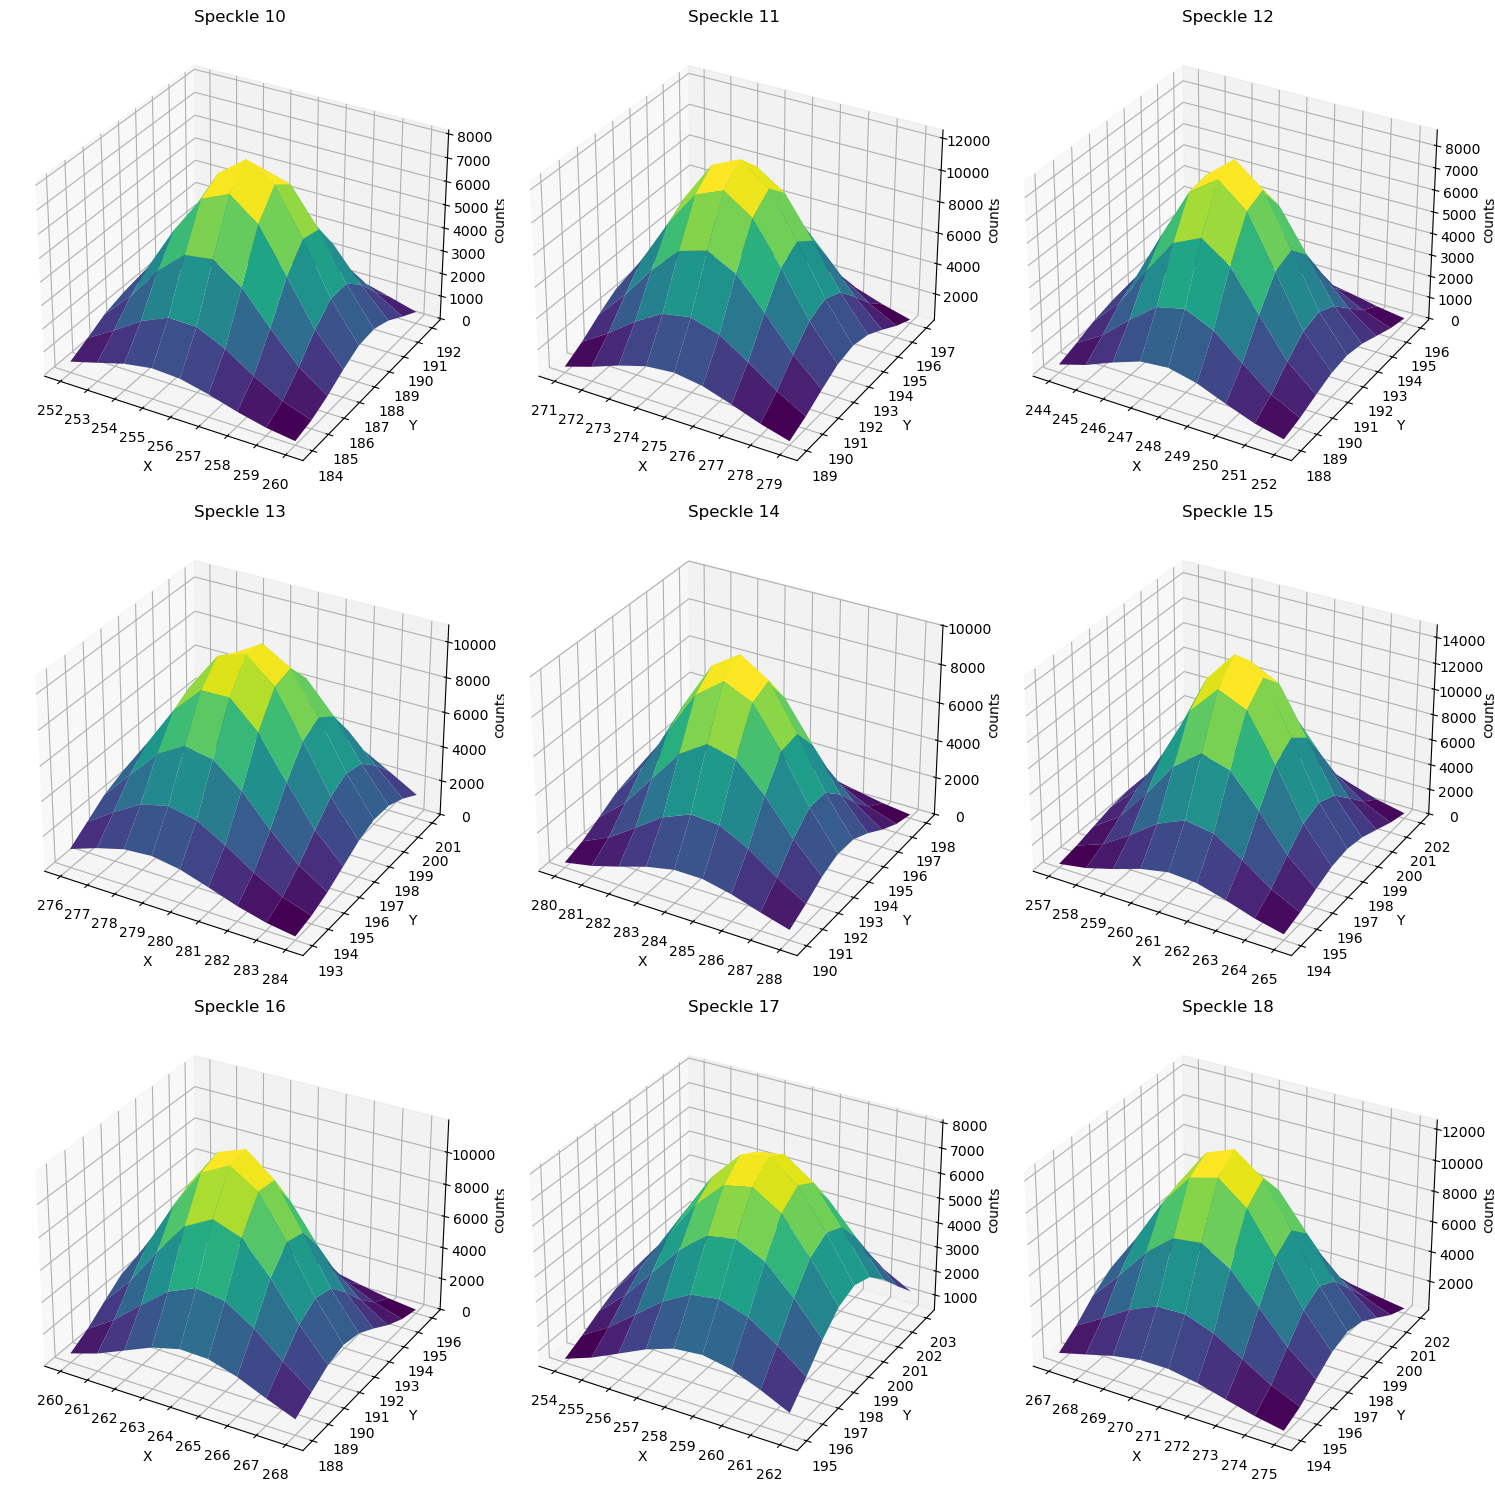

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fwhm_results = []
speckle_index =10  # Change this index to plot a different speckle
fig = plt.figure(figsize=(15, 15))

for i in range(9):
    speckle = filtered_speckles[speckle_index + i]
    y_ref, x_ref = speckle  
    y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    masked_data = data.copy() 
    distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
    circular_mask = distance <= radius
    masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    
    # se attivo fa il fit in una regione circolare
    masked_data = np.where(circular_mask, masked_data, 0) 

    # Set border pixels to 0
    masked_data[0, :] = 0
    masked_data[-1, :] = 0
    masked_data[:, 0] = 0
    masked_data[:, -1] = 0

    gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
    gaussian_model.amplitude.min = speckle_threshold
    gaussian_model.amplitude.max = masked_data.max()
    gaussian_model.x_mean.min = x_ref - 1
    gaussian_model.x_mean.max = x_ref + 1
    gaussian_model.y_mean.min = y_ref - 1
    gaussian_model.y_mean.max = y_ref + 1
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gaussian_model, x, y, masked_data)
    fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
    fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
    fwhm_results.append((fwhm_y, fwhm_x))

    ax = fig.add_subplot(3, 3, i + 1, projection='3d')
    ax.plot_surface(x, y, fitted_model(x, y), cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('counts')
    ax.set_title(f'Speckle {speckle_index +i }')

plt.tight_layout()
plt.show()

## Residui

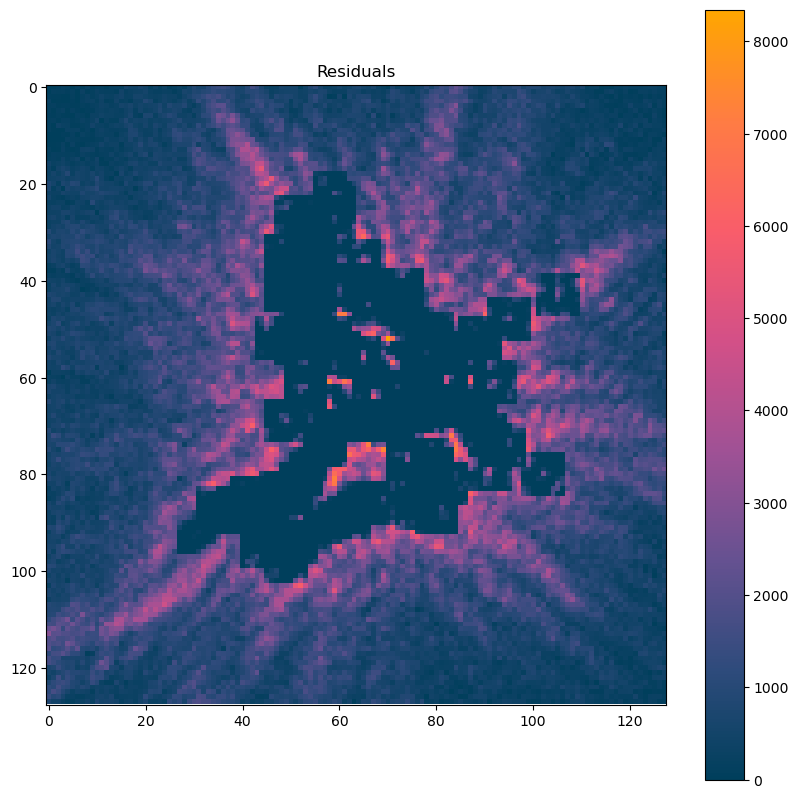

In [59]:
# Create a copy of the original data to store the residuals
residuals = data.copy()

# Loop through each speckle and subtract the fitted Gaussian model
for speckle in filtered_speckles:
    y_ref, x_ref = speckle  
    y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    masked_data = data #- speckle_threshold/2
    masked_data[masked_data < 0] = 0 
    masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    
    

    gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
    gaussian_model.amplitude.min = speckle_threshold
    gaussian_model.amplitude.max = masked_data.max()
    gaussian_model.x_mean.min = x_ref - 1
    gaussian_model.x_mean.max = x_ref + 1
    gaussian_model.y_mean.min = y_ref - 1
    gaussian_model.y_mean.max = y_ref + 1

    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gaussian_model, x, y, masked_data)

    # Subtract the fitted Gaussian model from the residuals image
    residuals[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1] -= fitted_model(x, y)
residuals[residuals < 0] = 0

zoom_factor = 4

center_x = int(filtered_speckles[:, 1].mean())
center_y = int(filtered_speckles[:, 0].mean())

x1 = max(center_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(center_x + data.shape[1] // (2 * zoom_factor), data.shape[1])
y1 = max(center_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(center_y + data.shape[0] // (2 * zoom_factor), data.shape[0])
zoomed_residuals = residuals[y1:y2, x1:x2]
plt.figure(figsize=(10, 10))
plt.imshow(zoomed_residuals, cmap=custom_cmap)
plt.colorbar()
plt.title("Residuals")
plt.show()

# Istogrammi di medie e mediane delle FWHM di tutte le immagini

In [10]:
from astropy.stats import sigma_clip


# Ask for confirmation before continuing
confirmation = input("Do you want to continue with the code execution? Y/N:")

if confirmation == 'y':
    # Continue with the code execution
    pass
else:
    print("Code stopped.")
    raise SystemExit

print('Executing code...')

fwhm_mean_all = []
fwhm_median_all = []
fwhm_std_all = []
centroid_all = []   # first coordinate in the array is the Y
rms_all = []        # first coordinate in the array is the Y

for imagenumber in range(len(ome_data)-4000):

    data_raw = ome_data[imagenumber]
    data_clean = data_raw.copy()
    poisson_error = np.sqrt(data_raw)

    # Estimate the background error (assuming a constant background level)
    background_level = np.median(data_raw)
    background_error = np.sqrt(background_level)

    # Calculate the noise value using the root sum square (RSS) of the Poissonian error and background error
    noise = np.sqrt(np.mean(poisson_error**2) + background_error**2)

    # Estimate the background using the total error
    background_estimate = data_raw - noise
    background_estimate[background_estimate < 0] = 0

    data = data_raw - background_level
    data[data < 0] = 0

    ###############################################################################

    speckle_coords = np.column_stack(np.where(data > speckle_threshold))
    real_speckles = []

    for coord in speckle_coords:
        y, x = coord
        max_count = data[y, x]
        speckle = coord
        
        # Check the surrounding pixels within the radius
        for dy in range(-check_radius, check_radius + 1):
            for dx in range(-check_radius, check_radius + 1):
                ny, nx = y + dy, x + dx
                if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                    if data[ny, nx] > max_count:
                        max_count = data[ny, nx]
                        speckle = [ny, nx]
                        
        if not any(np.array_equal(speckle, x) for x in real_speckles):
            real_speckles.append(speckle)
            
    real_speckles = np.array(real_speckles)


    filtered_speckles = []

    for speckle in real_speckles:
        y, x = speckle
        max_count = data[y, x]
        keep_speckle = True
        
        # Check for adjacent speckles
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                ny, nx = y + dy, x + dx
                if [ny, nx] in filtered_speckles:
                    if data[ny, nx] > max_count:
                        keep_speckle = False
                    else:
                        filtered_speckles.remove([ny, nx])
        
        if keep_speckle:
            filtered_speckles.append([y, x])
        
    filtered_speckles = np.array(filtered_speckles)

    ############################################################################################################
    
    
    fwhm_single_image = []

    
    fwhm_single_image, centers = fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale)

    #fwhm_results = []
    #fwhm_single_image = []
    # for speckle in filtered_speckles:
    #     y_ref, x_ref = speckle  
    #     masked_data = data.copy() 
    #     y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    #     #distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
    #     #circular_mask = distance <= radius
    #     masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    #     masked_data[masked_data < 0] = 0 
        
    #     ###########################################################################
    #     #Se attivo, fa il fit in una regione circolare
    #     #masked_data = np.where(circular_mask, masked_data, 0)
    #     ##############################################################################
    
    #     # Set border pixels to 0
    #     masked_data[0, :] = 0
    #     masked_data[-1, :] = 0
    #     masked_data[:, 0] = 0
    #     masked_data[:, -1] = 0

    #     gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
    #     gaussian_model.amplitude.min = speckle_threshold
    #     gaussian_model.amplitude.max = masked_data.max()
    #     gaussian_model.x_mean.min = x_ref - 1
    #     gaussian_model.x_mean.max = x_ref + 1
    #     gaussian_model.y_mean.min = y_ref - 1
    #     gaussian_model.y_mean.max = y_ref + 1

    #     fitter = fitting.LevMarLSQFitter()
    #     fitted_model = fitter(gaussian_model, x, y, masked_data)

    #     fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
    #     fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
    #     fwhm_results.append((fwhm_y, fwhm_x))

    # fwhm_single_image = np.array(fwhm_results)

#########################################################################################

    # sigma clipping
    #clipped_fwhm_single_image = sigma_clip(fwhm_single_image[:, 1], sigma=2, maxiters=5)  # eventualmente cambiare il sigma
    #clipped_fwhm_tot_x = sigma_clip(fwhm_single_image[:, 1], sigma=2, maxiters=5)
    #clipped_fwhm_y = sigma_clip(fwhm_tot_single_image[:, 0], sigma=2, maxiters=5)
    fwhm_x_mean = np.mean(fwhm_single_image[:, 1])
    fwhm_x_std = np.std(fwhm_single_image[:, 1])
    fwhm_x_tot_clean = fwhm_single_image[(fwhm_single_image[:, 1] > fwhm_x_mean - 3 * fwhm_x_std) & 
                                     (fwhm_single_image[:, 1] < fwhm_x_mean + 3 * fwhm_x_std)]
    #fwhm_x_tot_clean = fwhm_single_image[~fwhm_x_clipped.mask]
   
    mean_clipped_fwhm = np.mean(fwhm_x_tot_clean)
    median_clipped_fwhm = np.ma.median(fwhm_x_tot_clean)
    std_clipped_fwhm = np.std(fwhm_x_tot_clean)
    
    centroid = (np.mean(centers[:,0]), np.mean(centers[:,1])) 
    rms = (np.sqrt(np.mean((centers[:,0] - centroid[0])**2)), np.sqrt(np.mean((centers[:,1] - centroid[1])**2)))
    
    # salva nei vettori da mettere nell'istogramma alla fine
    fwhm_mean_all.append(mean_clipped_fwhm)
    fwhm_median_all.append(median_clipped_fwhm)
    fwhm_std_all.append(std_clipped_fwhm)
    rms_all.append(rms)
    centroid_all.append(centroid)
    

    if imagenumber % 100 == 0:
        print(imagenumber,'/',len(ome_data))
    
print('Done')



Executing code...
0 / 5000
100 / 5000
200 / 5000
300 / 5000
400 / 5000
500 / 5000
600 / 5000


700 / 5000
800 / 5000
900 / 5000
Done


In [11]:
print (len(fwhm_median_all))

1000


# Istogrammi

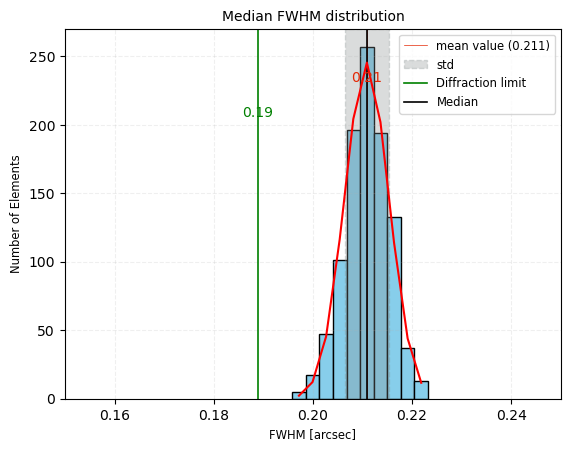

In [13]:


arr = fwhm_median_all
#arr=fwhm_mean_all

num_bins= int(len(arr) / 100)
bin_counts, bins, _ = plt.hist(arr, bins=num_bins, histtype='bar', align='mid', color='skyblue', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('FWHM [arcsec]', fontsize='small')
plt.ylabel('Number of Elements', fontsize='small')
plt.title('Median FWHM distribution', fontsize='medium')
plt.xlim(0.15, 0.25)
plt.axvline(np.mean(arr), ls='-', color='#e52704', label=f'mean value ({np.mean(arr):.3f})', linewidth=0.5)
plt.axvspan(xmin=np.mean(arr)-np.std(arr), xmax=np.mean(arr)+np.std(arr), alpha=0.3, color='#858e8e', label='std', ls='--')
plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=1.2, label='Diffraction limit')
plt.axvline(np.median(arr), color='black', linestyle='-', linewidth=1.2, label='Median')
plt.text(np.mean(arr), max(bin_counts) * 0.9, f"{np.mean(arr):.2f}", color='#e52704', ha='center')
plt.text(diffraction_limit_arcseconds, max(bin_counts) * 0.8, f"{diffraction_limit_arcseconds:.2f}", color='green', ha='center')
x, y = gaussiana(bins, np.mean(arr), np.std(arr))
plt.plot(x, y * len(arr) * (bins[1] - bins[0]), color='red', linestyle='-') 
plt.legend(loc='best', fontsize='small')


# Fotometria d'apertura 

(2048, 2048)
2048


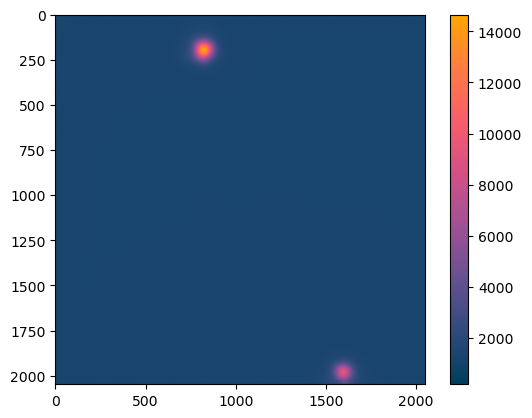

In [ ]:
import tifffile
from astropy.io import fits


data_photometry = np.sum(ome_data, axis=0)
# plt.figure(figsize=(10, 10))
# plt.imshow(data_photometry, cmap=custom_cmap)
# plt.colorbar()
# plt.title("Stacked Image")
# plt.show()

#file = (r"C:\Users\buonc\Desktop\doppie_50.fits")
#file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\BD31424__1_MMStack_Pos0.ome.tif")
#data_photometry = tifffile.imread(file)
#Read the FITS file
#with fits.open(file) as hdul:
#    data_photometry = hdul[0].data

# #n_image = 9

ref_image = data_photometry.copy()
print(ref_image.shape)
print(len(data_photometry))
plt.imshow(ref_image, cmap=custom_cmap)
plt.colorbar()



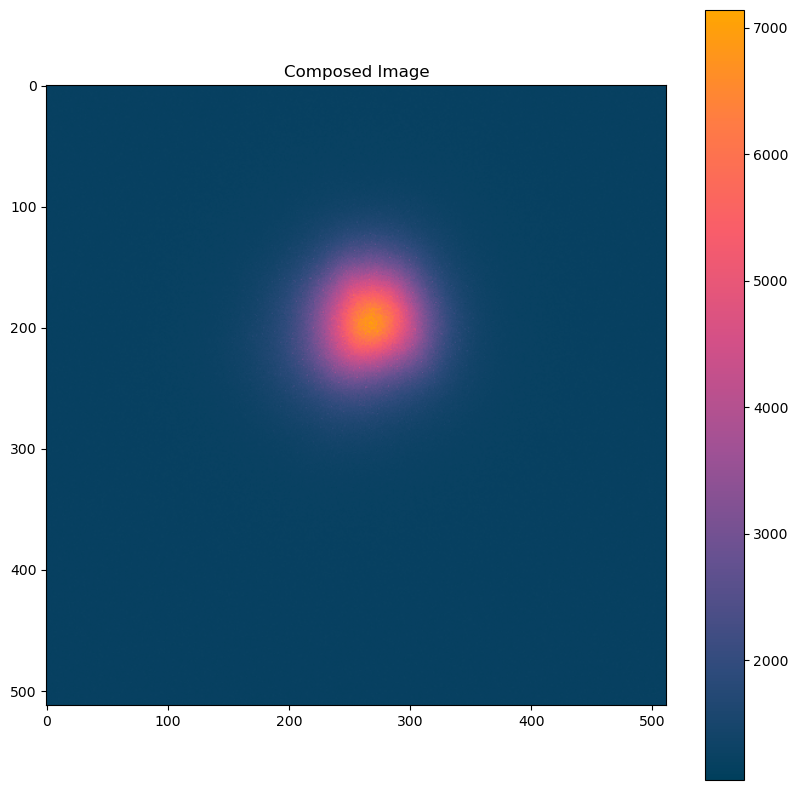

In [19]:
# Calculate the average intensity image from the stack
data_photometry = np.mean(ome_data, axis=0)

# Plot the average intensity image
plt.figure(figsize=(10, 10))
plt.imshow(data_photometry, cmap=custom_cmap)
plt.colorbar()
plt.title("Composed Image")
plt.show()
ref_image = data_photometry.copy()

# Smoothing dell'immagine (da rivedere)

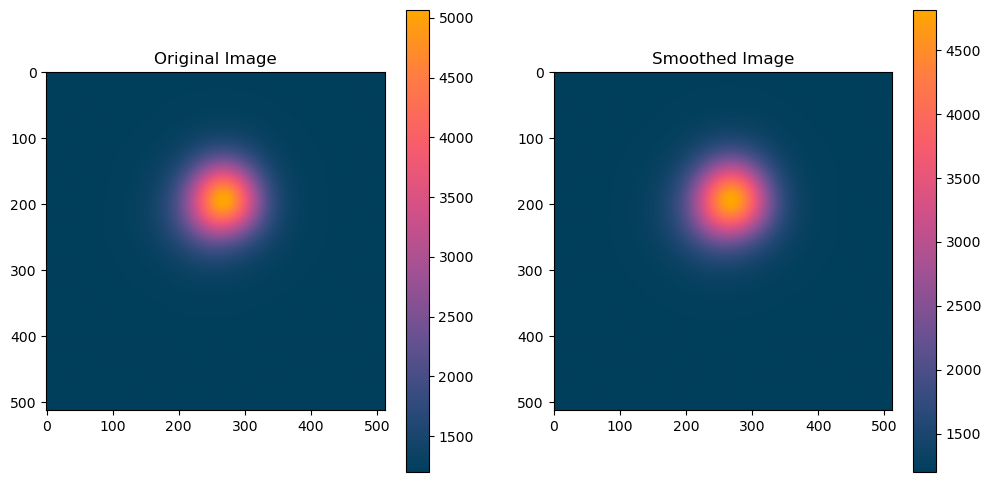

In [101]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian smoothing to the image
sigma = 10  # Standard deviation for Gaussian kernel
smoothed_image = gaussian_filter(ref_image, sigma=sigma)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ref_image, cmap=custom_cmap)
plt.colorbar()
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(smoothed_image, cmap=custom_cmap)
plt.colorbar()
plt.title("Smoothed Image")

plt.show()

ref_image = np.copy(smoothed_image)

In [97]:
from astropy.io import fits

# Save the smoothed image to a FITS file
hdu = fits.PrimaryHDU(smoothed_image)
hdu.writeto('c:/Users/buonc/Desktop/smoothed_image.fits', overwrite=True)

In [12]:
immagine = ref_image  #sceglie l'immagine
hdu = fits.PrimaryHDU(immagine)
hdu.writeto('c:/Users/buonc/Desktop/stelle_doppie.fits', overwrite=True)

Number of sources found: 1


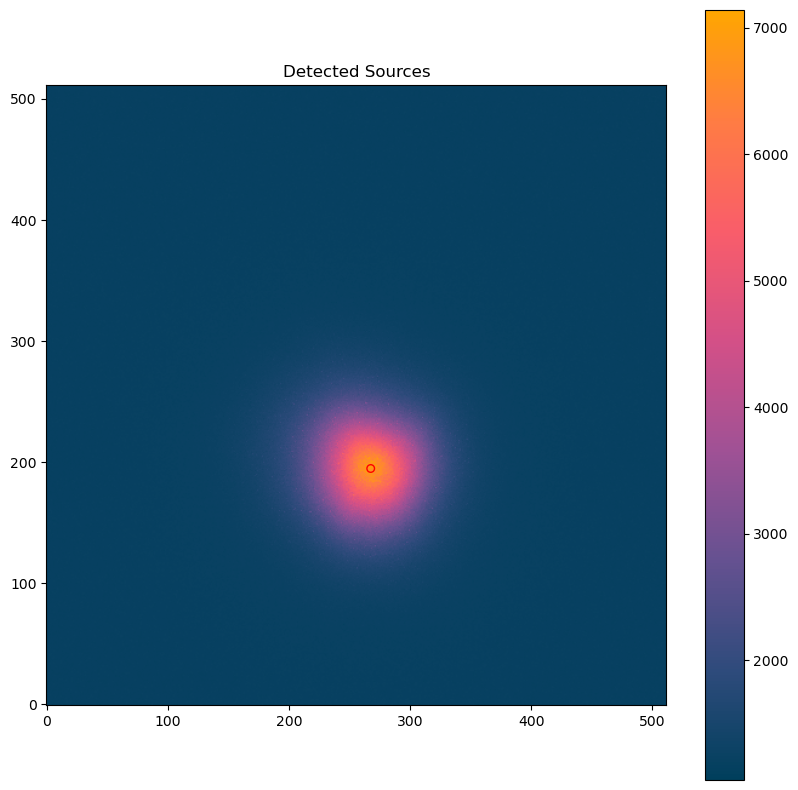

In [7]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats

# Calculate the background statistics
mean, median, std = sigma_clipped_stats(ref_image, sigma=3.0)

# Initialize the DAOStarFinder 
daofind = DAOStarFinder(fwhm=50.0, threshold=20.*std)

# Find the sources in the image
sources = daofind(ref_image - median)

# Print the number of sources found
print(f"Number of sources found: {len(sources)}")

# Plot the sources on the image
plt.figure(figsize=(10, 10))
plt.imshow(ref_image, cmap=custom_cmap, origin='lower')
plt.colorbar()
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none')
plt.title('Detected Sources')
plt.show()

In [39]:
for source in sources:
    print(f"Source ID: {source['id']}, X: {source['xcentroid']}, Y: {source['ycentroid']}")
    
print(sources[1]['xcentroid'])

Source ID: 1, X: 267.3588344371413, Y: 194.7913453305824


IndexError: index 1 out of range for table with length 1

max value no cleaning = 7140.8188
Background mean counts per pixel: 1213.7578847591078
max counts in the image: 5927.060915240892
Final flux= 39926750.07786194 +- 4068.4092071894693
68 39926750.07786194
R 80 = 69 pixels, 2.6012999999999997 arcsec
42 39926750.07786194
R 50 = 43 pixels, 1.6211 arcsec
FWHM  = 3.2422 arcsec
Flux at R50 = 20237568.327725925 +- 1470.0974446146822


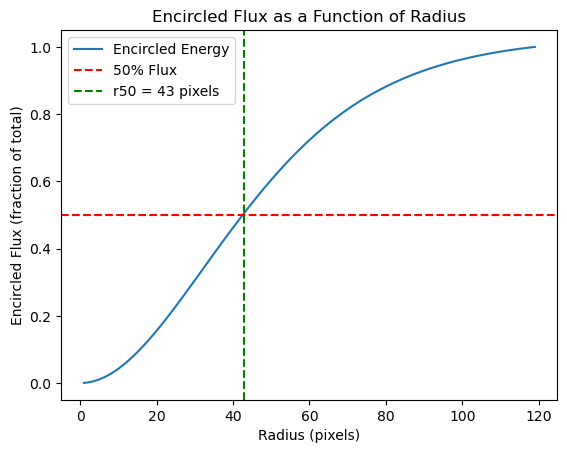

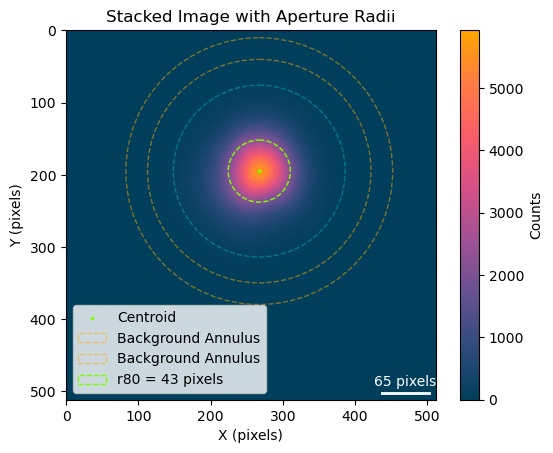

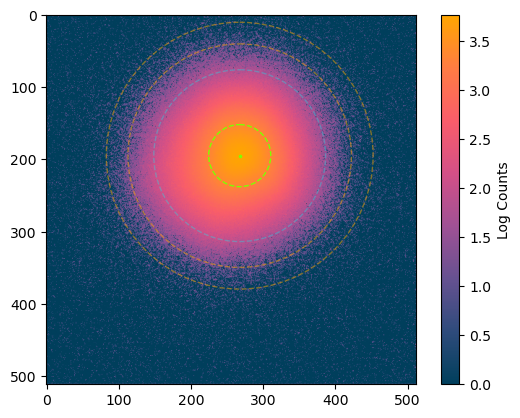

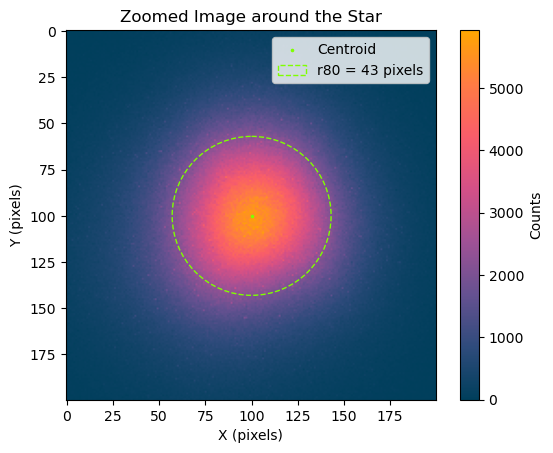

In [23]:
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
from astropy.io import fits


# SCEGLIE IL CENTROIDE DI RIFERIMENTO ###############################################################
#####################################################################################################
centroid_x, centroid_y = sources[0]['xcentroid'], sources[0]['ycentroid']
center = (centroid_x, centroid_y)
###########################################################################################################
###########################################################################################################


max_radius = min(center[1], center[0], ref_image.shape[0] - center[0], ref_image.shape[1] - center[1])
max_radius_ds9 = 120 # raggio della PSF visto in DS9 (controllare da lì prima di partire col codice)

inner_radius = max_radius - 40
outer_radius = max_radius - 10
annulus_aperture = CircularAnnulus(center, r_in=inner_radius, r_out=outer_radius)

# Perform aperture photometry on the annulus to get the background
annulus_stats = ApertureStats(ref_image, annulus_aperture)
background_mean = annulus_stats.mean
image_stack = ref_image.copy() - background_mean
image_stack[image_stack < 0] = 0

print(f'max value no cleaning = {np.max(ref_image)}')
print(f"Background mean counts per pixel: {background_mean}")
print(f'max counts in the image: {np.max(image_stack)}')


radii = np.arange(1, max_radius_ds9, 1)

fluxes = []
flux_errors = []

# Create an error array with the same shape as image_stack
error_array = np.full(image_stack.shape, std)

for r in radii:
    aperture = CircularAperture(center, r)
    phot_table = aperture_photometry(image_stack, aperture, error=error_array)
    flux = phot_table['aperture_sum'][0]
    flux_error = phot_table['aperture_sum_err'][0]
    if len(fluxes) > 0 and (flux - fluxes[-1]) / fluxes[-1] < 0.0001:
        break
    fluxes.append(flux)
    flux_errors.append(flux_error)
print(f"Final flux= {flux} +- {flux_error}")

fluxes = np.array(fluxes)
total_flux = fluxes[-1]

#print(fluxes/total_flux, radii)  


r80_index = np.where(fluxes >= 0.8 * total_flux)[0][0]  ### qui si sceglie r
r80 = radii[r80_index]
print(r80_index, total_flux )
print(f"R 80 = {r80} pixels, {r80 * plate_scale} arcsec")

r80_index = np.where(fluxes >= 0.50 * total_flux)[0][0]  ### qui si sceglie r
r80 = radii[r80_index]
print(r80_index, total_flux )
print(f"R 50 = {r80} pixels, {r80 * plate_scale} arcsec")
print(f"FWHM  = {r80*2*plate_scale} arcsec")
print(f"Flux at R50 = {fluxes[r80_index]} +- {flux_errors[r80_index]}")



plt.figure()
plt.plot(radii[:len(fluxes)], fluxes / total_flux , label='Encircled Energy')
plt.axhline(0.5, color='r', linestyle='--', label='50% Flux')
plt.axvline(r80, color='g', linestyle='--', label=f'r50 = {r80} pixels')
plt.xlabel('Radius (pixels)')
plt.ylabel('Encircled Flux (fraction of total)')
plt.legend()
plt.title('Encircled Flux as a Function of Radius')
plt.show()

plt.figure()
plt.imshow(image_stack, cmap=custom_cmap)
plt.colorbar(label='Counts')
plt.scatter(center[0], center[1] , color='chartreuse', marker='.', s=10, label='Centroid')


aperture = plt.Circle(center, radii[len(fluxes)-1], color='cyan', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_patch(aperture)

annulus_aperture_patch = plt.Circle(center, outer_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)
annulus_aperture_patch = plt.Circle(center, inner_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)

circle_r80 = plt.Circle(center, r80, color='chartreuse', fill=False, linestyle='--', label=f'r80 = {r80} pixels')
plt.gca().add_patch(circle_r80)


scalebar_length_pixels = 65  
scalebar = plt.Line2D([image_stack.shape[1] - scalebar_length_pixels - 10, image_stack.shape[1] - 10],
                      [image_stack.shape[0] - 10, image_stack.shape[0] - 10],
                      color='white', linewidth=2)
plt.gca().add_line(scalebar)
plt.text(image_stack.shape[1] - scalebar_length_pixels / 2 - 10, image_stack.shape[0] - 20, '65 pixels', color='white', ha='center')


plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()
plt.title('Stacked Image with Aperture Radii')
plt.show()

# Show the image with logarithmic counts
plt.figure()
plt.imshow(np.log10(image_stack +1), cmap=custom_cmap)
plt.colorbar(label='Log Counts')
plt.scatter(center[0] , center[1], color='chartreuse', marker='.', s=10, label='Centroid')


aperture = plt.Circle(center, radii[len(fluxes)-1], color='cyan', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_patch(aperture)

annulus_aperture_patch = plt.Circle(center, outer_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)
annulus_aperture_patch = plt.Circle(center, inner_radius, color='orange', fill=False, linestyle='--', alpha=0.5) #label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)

circle_r80 = plt.Circle(center, r80, color='chartreuse', fill=False, linestyle='--', label=f'r80 = {r80} pixels')
plt.gca().add_patch(circle_r80)


zoom_size = 100  
x_min = int(center[0] - zoom_size )
x_max = int(center[0] + zoom_size )
y_min = int(center[1] - zoom_size )
y_max = int(center[1] + zoom_size )

zoomed_image = image_stack[y_min:y_max, x_min:x_max]

plt.figure()
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.colorbar(label='Counts')
plt.scatter(zoom_size , zoom_size , color='chartreuse', marker='.', s=10, label='Centroid')

aperture = plt.Circle((zoom_size , zoom_size ), r80, color='chartreuse', fill=False, linestyle='--', label=f'r80 = {r80} pixels')
plt.gca().add_patch(aperture)

plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()
plt.title('Zoomed Image around the Star')
plt.show()




In [112]:

fwhm_radians = r80*2*plate_scale * (np.pi / 180) / 3600

r0 = wavelength / fwhm_radians

print(f"r0 = {r0:.6f} [m]")



r0 = 0.043452 [m]


# Fit gaussiano stelle 

Fitted FWHM: 2.92 x 3.03 arcseconds
Fitted Centroid: (np.float64(266.5654334658825), np.float64(194.69645451749255))
Fitted Max Amplitude: 5430.3516
Original Centroid: (267, 194)
Original Max Amplitude: 5930.3516


C:\Users\buonc\AppData\Local\Temp\ipykernel_5584\3988985710.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


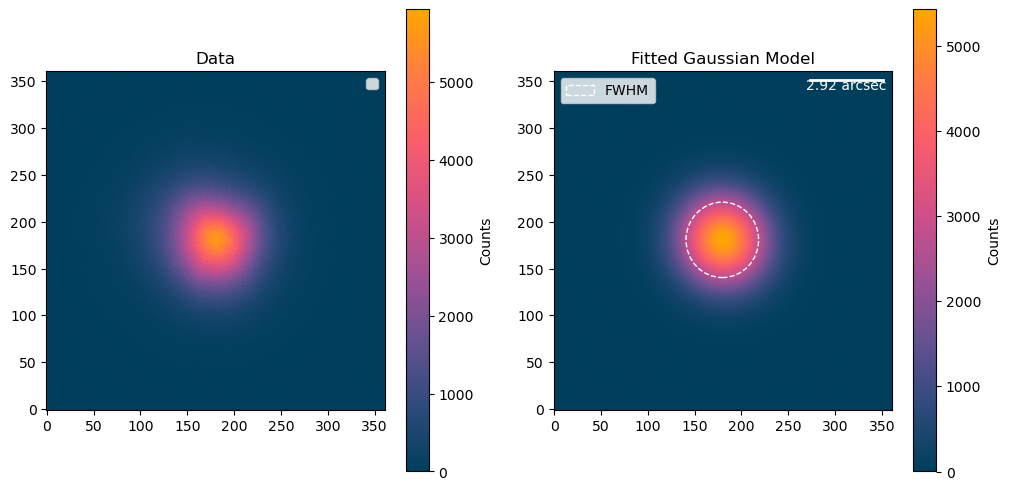

Max value of the residuals: 757.4494638877843
Min value of the residuals: -871.6160330589701
Mean value of the residuals: 23.10367205011896


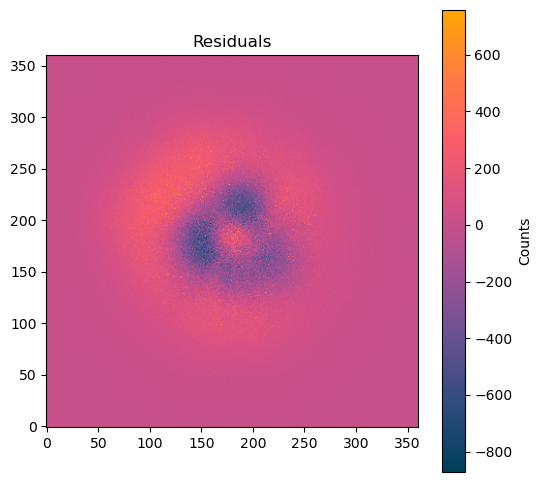

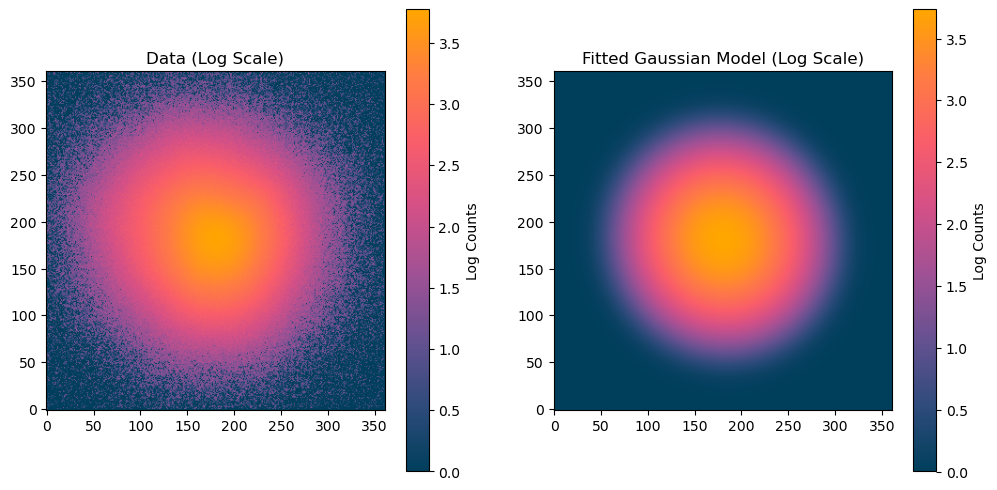

C:\Users\buonc\AppData\Local\Temp\ipykernel_5584\3988985710.py:119: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(residuals + 1), cmap=custom_cmap, origin='lower')


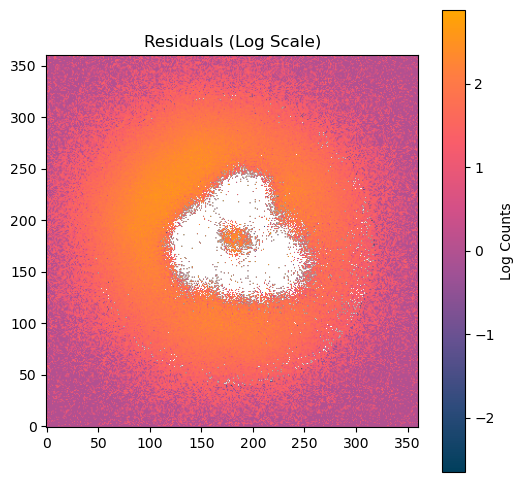

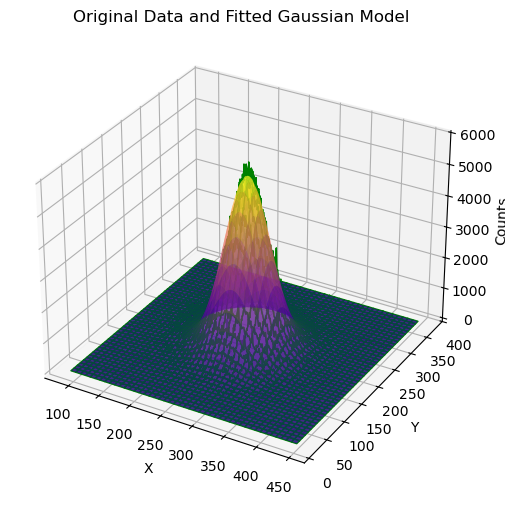

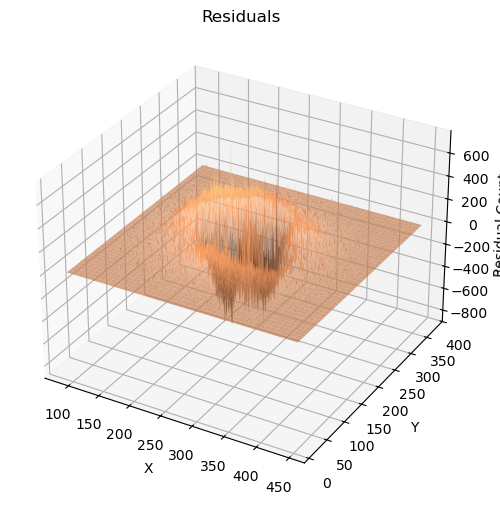

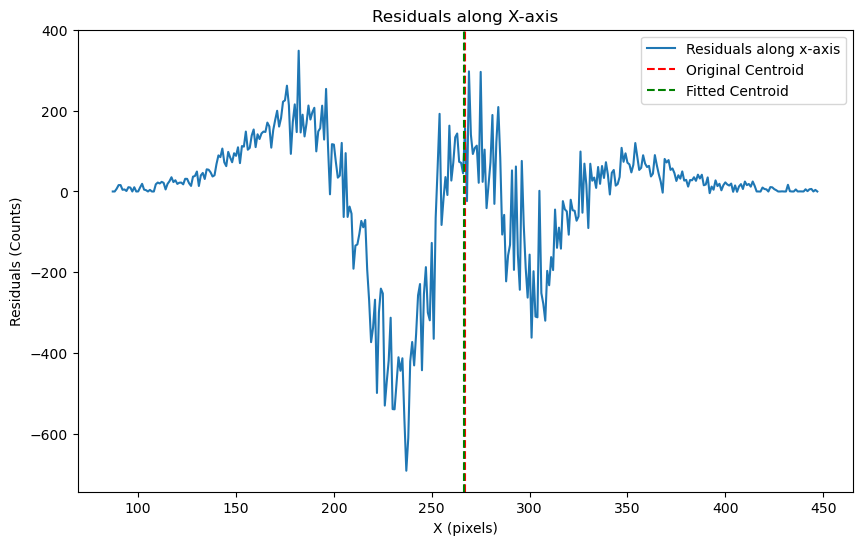

r0 = 0.048280 [m]


In [ ]:
from astropy.modeling import models, fitting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D



ref_image = data_photometry#[n_image]
# rebin_factor = 2
# def rebin_image(image, rebin_factor):
#     shape = (image.shape[0] // rebin_factor, rebin_factor,
#              image.shape[1] // rebin_factor, rebin_factor)
#     return image.reshape(shape).mean(-1).mean(1)

# rebinned_data = rebin_image(data_photometry[n_image], rebin_factor)
# ref_image = rebinned_data.copy()

back = np.median(ref_image)
image_clean = ref_image.copy() - back
image_clean[image_clean<0] = 0
radius = 180

y_ref, x_ref = int(centroid_y), int(centroid_x)   # usa lo stesso centoride del fit con fotometria
y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]

masked_data = image_clean[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
# Set border pixels to 0
masked_data[0, :] = 0
masked_data[-1, :] = 0
masked_data[:, 0] = 0
masked_data[:, -1] = 0

gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=30, y_stddev=30)  # prima erano 10 e 10
gaussian_model.amplitude.min = masked_data.max() - 500
gaussian_model.amplitude.max = masked_data.max()
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(gaussian_model, x, y, masked_data)

fwhm_x = fitted_model.x_fwhm *plate_scale
fwhm_y = fitted_model.y_fwhm  *plate_scale

#fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
#fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale

print(f"Fitted FWHM: {fwhm_x:.2f} x {fwhm_y:.2f} arcseconds")
fitted_centroid = (fitted_model.x_mean.value, fitted_model.y_mean.value)
fitted_amplitude = fitted_model.amplitude.value
original_centroid = (x_ref, y_ref)
original_amplitude = masked_data.max()

print(f"Fitted Centroid: {fitted_centroid}")
print(f"Fitted Max Amplitude: {fitted_amplitude}")
print(f"Original Centroid: {original_centroid}")
print(f"Original Max Amplitude: {original_amplitude}")

####################################################
#######################   PLOTS
####################################################
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(masked_data, cmap=custom_cmap, origin='lower')
plt.title('Data')
plt.colorbar(label='Counts')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(fitted_model(x, y), cmap=custom_cmap, origin='lower')
plt.title('Fitted Gaussian Model')
plt.colorbar(label='Counts')

fwhm_arcsec_x = fwhm_x / plate_scale
fwhm_arcsec_y = fwhm_y / plate_scale

ellipse = Ellipse((fitted_model.x_mean.value - x.min(), fitted_model.y_mean.value - y.min()), 
                     fwhm_arcsec_x, fwhm_arcsec_y, color='white', fill=False, linestyle='--', label='FWHM')
plt.gca().add_patch(ellipse)

plt.legend()

scalebar_length_pixels = fwhm_x / plate_scale  
scalebar = plt.Line2D([masked_data.shape[1] - scalebar_length_pixels - 10, masked_data.shape[1] - 10],
                      [masked_data.shape[0] - 10, masked_data.shape[0] - 10],
                      color='white', linewidth=2)
plt.gca().add_line(scalebar)
plt.text(masked_data.shape[1] - scalebar_length_pixels / 2 - 10, masked_data.shape[0] - 20, f'{fwhm_x:.2f} arcsec', color='white', ha='center')
plt.show()

# residuals
residuals = masked_data - fitted_model(x, y)
print(f"Max value of the residuals: {residuals.max()}")
print(f"Min value of the residuals: {residuals.min()}")
print(f"Mean value of the residuals: {residuals.mean()}")

plt.figure(figsize=(6, 6))
plt.imshow(residuals, cmap=custom_cmap, origin='lower')
plt.title('Residuals')
plt.colorbar(label='Counts')
plt.show()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.log10(masked_data + 1), cmap=custom_cmap, origin='lower')
plt.title('Data (Log Scale)')
plt.colorbar(label='Log Counts')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(fitted_model(x, y) + 1), cmap=custom_cmap, origin='lower')
plt.title('Fitted Gaussian Model (Log Scale)')
plt.colorbar(label='Log Counts')

plt.show()

# residuals in logarithmic scale
plt.figure(figsize=(6, 6))
plt.imshow(np.log10(residuals + 1), cmap=custom_cmap, origin='lower')
plt.title('Residuals (Log Scale)')
plt.colorbar(label='Log Counts')
plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

########################################
############### 3D PLOTS  ##############
########################################

ax.plot_surface(x, y, masked_data, cmap='viridis', edgecolor='green', alpha=0.7)
ax.set_title('Original Data and Fitted Gaussian Model')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Counts')

ax.plot_surface(x, y, fitted_model(x, y), cmap='plasma', edgecolor='none', alpha=0.5)
plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, residuals, cmap='copper', edgecolor='none', alpha=0.7)
ax.set_title('Residuals')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Residual Counts')
plt.show()

# Plot the residuals along the x-axis
plt.figure(figsize=(10, 6))
plt.plot(x[0], residuals[residuals.shape[0] // 2], label='Residuals along x-axis')
plt.axvline(x=original_centroid[0], color='r', linestyle='--', label='Original Centroid')
plt.axvline(x=fitted_centroid[0] , color='g', linestyle='--', label='Fitted Centroid')
plt.xlabel('X (pixels)')
plt.ylabel('Residuals (Counts)')
plt.title('Residuals along X-axis')
plt.legend()
plt.show()


fwhm_radians = fwhm_arcsec_x*plate_scale * (np.pi / 180) / 3600

r0 = wavelength / fwhm_radians

print(f"r0 = {r0:.6f} [m]")

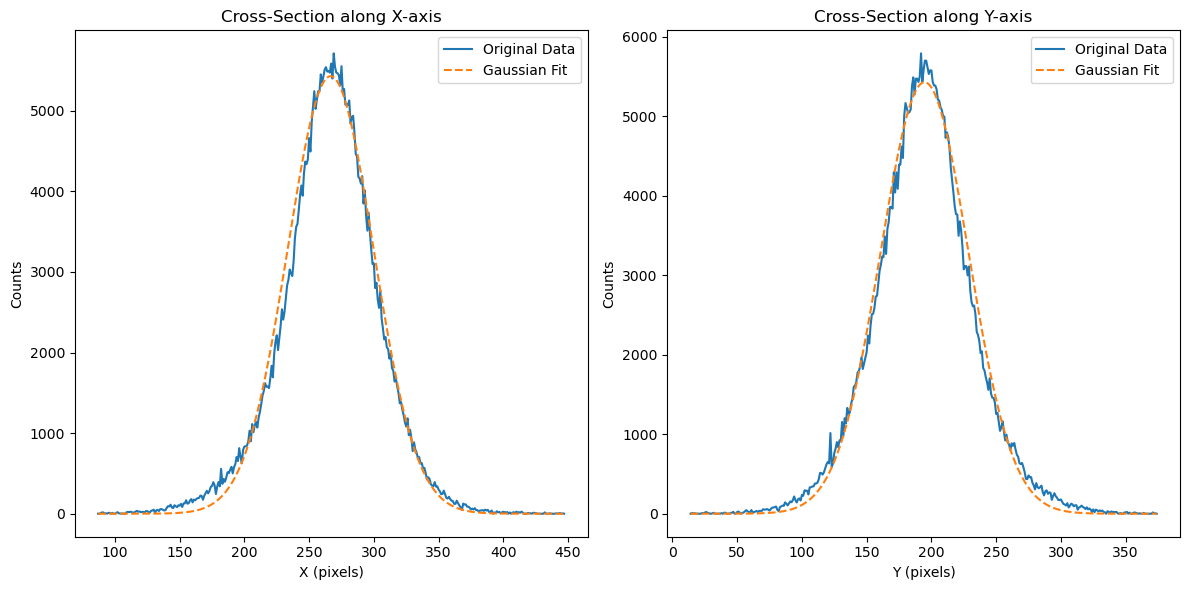

In [ ]:
# Extract the cross-sections of the Gaussian fit along the x and y axes
x_cross_section = fitted_model(x[radius, :], y[radius, :])
y_cross_section = fitted_model(x[:, radius], y[:, radius])

# Extract the original data cross-sections along the x and y axes
original_cross_section_x = masked_data[radius, :]
original_cross_section_y = masked_data[:, radius]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x[radius, :], original_cross_section_x, label='Original Data')
plt.plot(x[radius, :], x_cross_section, label='Gaussian Fit', linestyle='--')
plt.xlabel('X (pixels)')
plt.ylabel('Counts')
plt.title('Cross-Section along X-axis')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y[:, radius], original_cross_section_y, label='Original Data')
plt.plot(y[:, radius], y_cross_section, label='Gaussian Fit', linestyle='--')
plt.xlabel('Y (pixels)')
plt.ylabel('Counts')
plt.title('Cross-Section along Y-axis')
plt.legend()


# plt.subplot(1, 2, 1)
# plt.plot(radii[:len(fluxes)], fluxes / total_flux, label='Encircled Energy', linestyle='-.')
# plt.axvline(r80, color='g', linestyle='--', label=f'r80 = {r80} pixels')
# plt.axhline(0.5, color='r', linestyle='--', label='50% Flux')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(radii[:len(fluxes)], fluxes / total_flux, label='Encircled Energy', linestyle='-.')
# plt.axvline(r80, color='g', linestyle='--', label=f'r80 = {r80} pixels')
# plt.axhline(0.5, color='r', linestyle='--', label='50% Flux')
# plt.legend()

plt.tight_layout()
plt.show()


# Fit Moffat

C:\Users\buonc\AppData\Local\Temp\ipykernel_5584\3866209287.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Fitted FWHM: 2.86 x 2.86 arcseconds
Fitted Centroid: (np.float64(266.4988587113673), np.float64(194.7836506147349))
Fitted Max Amplitude: 38477369.41251777
Original Centroid: (267, 194)
Original Max Amplitude: 5930.3516
5275.680188330819


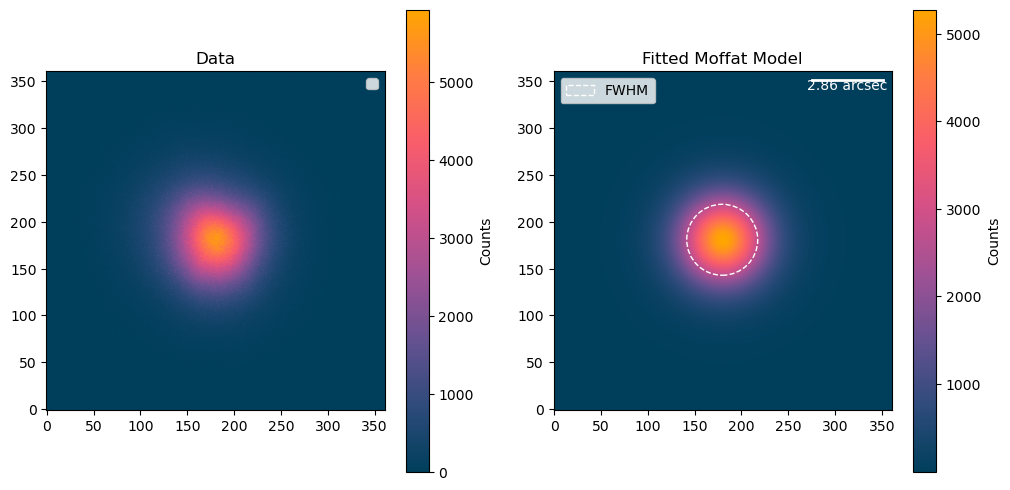

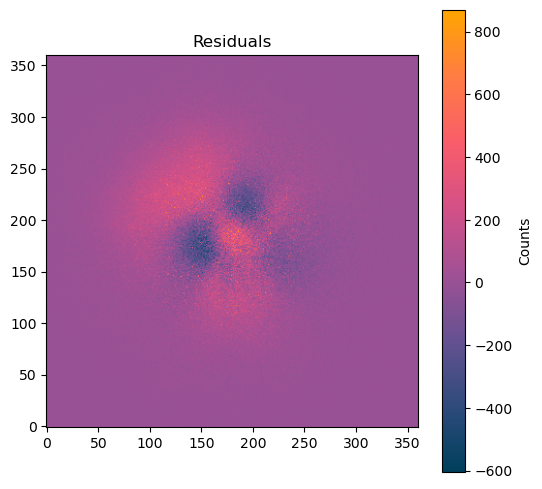

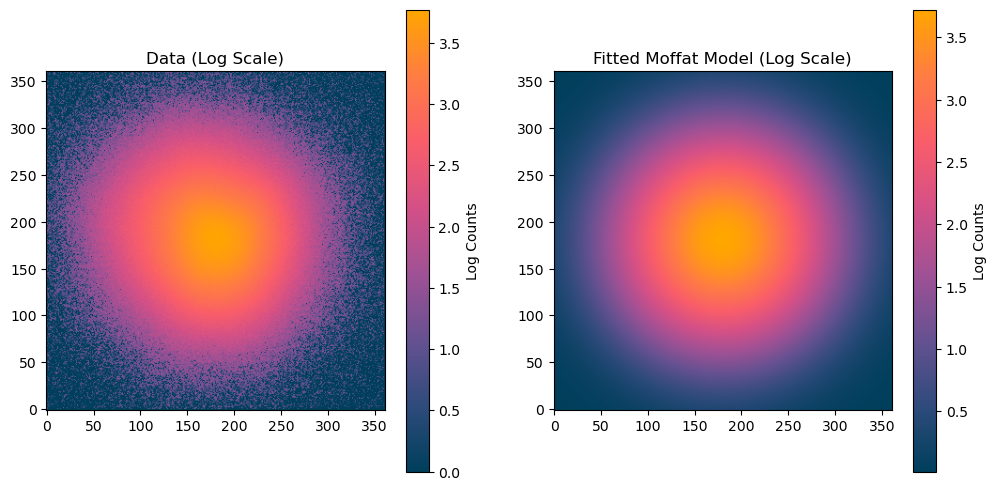

C:\Users\buonc\AppData\Local\Temp\ipykernel_5584\3866209287.py:94: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(residuals + 1), cmap=custom_cmap, origin='lower')


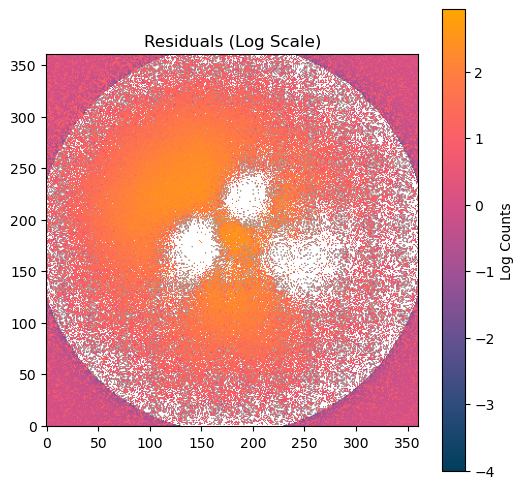

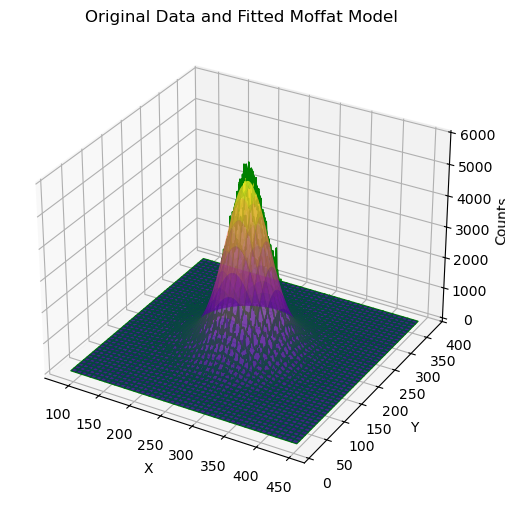

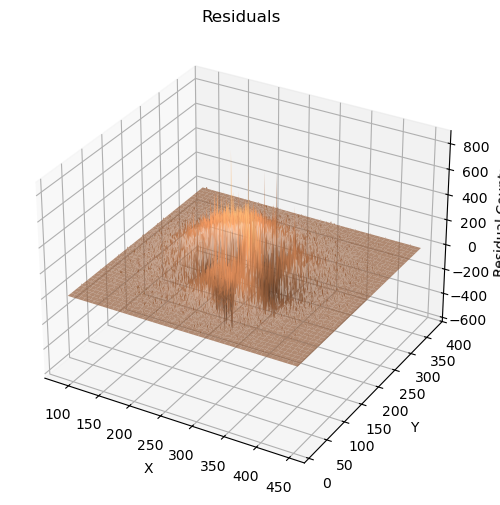

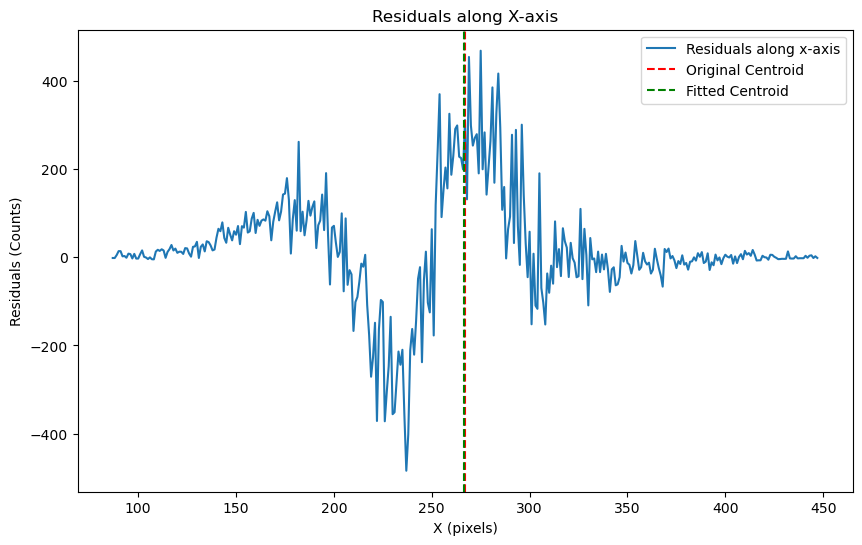

In [ ]:
from astropy.modeling import models, fitting
import numpy as np
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from photutils.psf import MoffatPSF

import matplotlib.pyplot as plt

# Define the Moffat model
moffat_model = MoffatPSF(flux = masked_data.max(), x_0=x_ref, y_0=y_ref, alpha=10, beta=2.5)
moffat_model.flux = masked_data.max()
moffat_model.alpha.fixed = False
moffat_model.beta.fixed = False

fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(moffat_model, x, y, masked_data)

fwhm_x = 2 * fitted_model.alpha.value * np.sqrt(2**(1/fitted_model.beta.value) - 1) * plate_scale
fwhm_y = fwhm_x  

print(f"Fitted FWHM: {fwhm_x:.2f} x {fwhm_y:.2f} arcseconds")
fitted_centroid = (fitted_model.x_0.value, fitted_model.y_0.value)
fitted_amplitude = fitted_model.flux.value
original_centroid = (x_ref, y_ref)
original_amplitude = masked_data.max()

print(f"Fitted Centroid: {fitted_centroid}")
print(f"Fitted Max Amplitude: {fitted_amplitude}")
print(f"Original Centroid: {original_centroid}")
print(f"Original Max Amplitude: {original_amplitude}")

print(np.max(fitted_model(x,y)))
####################################################
############   PLOTS
####################################################
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(masked_data, cmap=custom_cmap, origin='lower')
plt.title('Data')
plt.colorbar(label='Counts')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(fitted_model(x, y) , cmap=custom_cmap, origin='lower')
plt.title('Fitted Moffat Model')
plt.colorbar(label='Counts')

fwhm_arcsec_x = fwhm_x / plate_scale
fwhm_arcsec_y = fwhm_y / plate_scale

ellipse = Ellipse((fitted_model.x_0.value - x.min(), fitted_model.y_0.value - y.min()), 
                     fwhm_arcsec_x, fwhm_arcsec_y, color='white', fill=False, linestyle='--', label='FWHM')
plt.gca().add_patch(ellipse)

plt.legend()

scalebar_length_pixels = fwhm_x / plate_scale  
scalebar = plt.Line2D([masked_data.shape[1] - scalebar_length_pixels - 10, masked_data.shape[1] - 10],
                      [masked_data.shape[0] - 10, masked_data.shape[0] - 10],
                      color='white', linewidth=2)
plt.gca().add_line(scalebar)
plt.text(masked_data.shape[1] - scalebar_length_pixels / 2 - 10, masked_data.shape[0] - 20, f'{fwhm_x:.2f} arcsec', color='white', ha='center')
plt.show()

# residuals
residuals = masked_data - fitted_model(x, y) 

plt.figure(figsize=(6, 6))
plt.imshow(residuals, cmap=custom_cmap, origin='lower')
plt.title('Residuals')
plt.colorbar(label='Counts')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.log10(masked_data + 1), cmap=custom_cmap, origin='lower')
plt.title('Data (Log Scale)')
plt.colorbar(label='Log Counts')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(fitted_model(x, y) + 1), cmap=custom_cmap, origin='lower')
plt.title('Fitted Moffat Model (Log Scale)')
plt.colorbar(label='Log Counts')

plt.show()

# residuals in logarithmic scale
plt.figure(figsize=(6, 6))
plt.imshow(np.log10(residuals + 1), cmap=custom_cmap, origin='lower')
plt.title('Residuals (Log Scale)')
plt.colorbar(label='Log Counts')
plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

########################################
############### 3D PLOTS
########################################

ax.plot_surface(x, y, masked_data, cmap='viridis', edgecolor='green', alpha=0.7)
ax.set_title('Original Data and Fitted Moffat Model')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Counts')

ax.plot_surface(x, y, fitted_model(x, y), cmap='plasma', edgecolor='none', alpha=0.5)
plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, residuals, cmap='copper', edgecolor='none', alpha=0.7)
ax.set_title('Residuals')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Residual Counts')
plt.show()

# Plot the residuals along the x-axis
plt.figure(figsize=(10, 6))
plt.plot(x[0], residuals[residuals.shape[0] // 2], label='Residuals along x-axis')
plt.axvline(x=original_centroid[0], color='r', linestyle='--', label='Original Centroid')
plt.axvline(x=fitted_centroid[0] , color='g', linestyle='--', label='Fitted Centroid')
plt.xlabel('X (pixels)')
plt.ylabel('Residuals (Counts)')
plt.title('Residuals along X-axis')
plt.legend()
plt.show()


# Calculate the total counts of the fitted function
total_counts = np.sum(fitted_model(x, y))

# Calculate the cumulative sum of the fitted function's counts
cumulative_counts = np.cumsum(np.sort(fitted_model(x, y).ravel()))

# Find the radius that contains 80% of the total counts
target_counts = 0.8 * total_counts
radius_80_index = np.searchsorted(cumulative_counts, target_counts)
radius_80 = np.sqrt(radius_80_index / np.pi)



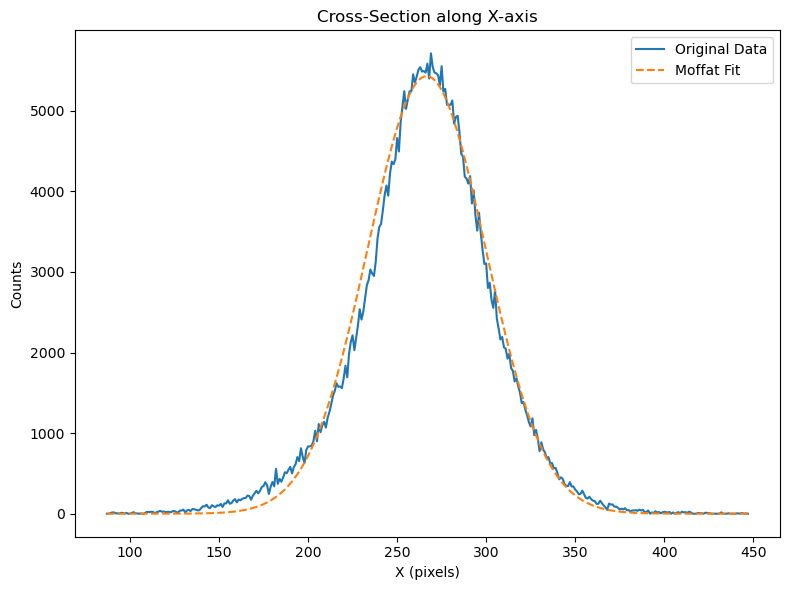

In [94]:
# Extract the cross-sections of the Moffat fit along the x axis
x_cross_section_moffat = fitted_model(x[radius, :], y[radius, :])

# Plot the cross-sections
plt.figure(figsize=(8, 6))

plt.plot(x[radius, :], original_cross_section_x, label='Original Data')
plt.plot(x[radius, :], x_cross_section_moffat, label='Moffat Fit', linestyle='--')
plt.xlabel('X (pixels)')
plt.ylabel('Counts')
plt.title('Cross-Section along X-axis')
plt.legend()

plt.tight_layout()
plt.show()
